# Quantifying Context-Mixing in Speech Transformers

---

Author: Hosein Mohebbi

_Thanks to Martijn Bentum, Tom Lentz, and Willem Zuidema for their helpful feedback during the notebook's preparation._

---

This notebook is based on the EMNLP 2023 paper: ["Homophone Disambiguation Reveals Patterns of Context Mixing in Speech Transformers"](https://aclanthology.org/2023.emnlp-main.513.pdf) and part of the [Interspeech 2025](https://www.interspeech2025.org/home) tutorial on [_Interpretability Techniques for Speech Models_](https://interpretingdl.github.io/speech-interpretability-tutorial/).

The notebook explores the ways to quantify patterns of *context-mixing* in speech ASR models at word-level.



# **Required Libraries**

In [ ]:
# @title Install Requirements
from IPython.display import clear_output
!pip install transformers==4.38.2
!pip install datasets==2.14.6
!git clone https://github.com/hmohebbi/context_mixing_toolkit.git
clear_output()

In [ ]:
# @title Import Libraries
import pandas as pd
from plotnine import *
from IPython.display import display
from IPython.display import Audio as AudioDisplay
from sklearn.metrics.pairwise import cosine_distances
import numpy as np
import torch
from datasets import load_dataset, Audio
from transformers import WhisperProcessor, Wav2Vec2Processor, AutoConfig
from context_mixing_toolkit.src.modeling_wav2vec2 import Wav2Vec2ForCTC
from context_mixing_toolkit.src.modeling_whisper import WhisperForConditionalGeneration
from transformers.modeling_attn_mask_utils import _prepare_4d_causal_attention_mask
from context_mixing_toolkit.src.utils import get_encoder_word_boundaries, normalize, normalize_

# **Homophone Dataset**

As a case study for analyzing word-level context mixing in speech representations, we use a dataset containing examples of homophones in French spoken language. In order to correctly transcribe these utterances, an ASR model has to rely on syntactic cues from the surrounding context to distinguish between words with identical pronunciations. This makes the task ideal for studying context mixing, as it provides a clear hypothesis about which parts of the context are most relevant for transcribing ambiguous target words.

In [ ]:
# @title An Audio Example

#@markdown Choose an audio example from CommonVoice (fr, test)
EXAMPLE_ID = 762  #@param {type: "slider", min: 0, max: 999}
EXAMPLE = load_dataset("hosein-m/french_homophone_asr", split="train").cast_column("audio", Audio(sampling_rate=16000))[EXAMPLE_ID]

display(AudioDisplay(EXAMPLE["audio"]["array"], rate=EXAMPLE["audio"]["sampling_rate"]))
print('Transcription: ', EXAMPLE['transcription'])
print('Cue Word: ', EXAMPLE['cue_word'])
print('Target Word: ', EXAMPLE['target_word'])
print('Second Target Word (if there is any): ', EXAMPLE['target_word_2'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Transcription:  On y trouve un aéroport.
Cue Word:  On
Target Word:  trouve
Second Target Word (if there is any):  None


# **ASR Models**

We provide two sets of ASR models that support French language:
* Whisper OpenAI (Radford et al., 2022) is a multilingual encoder-decoder multitask speech
model. The model is autoregressively trained to predict next token on a set
of supervised audio-to-text tasks such as multilingual speech transcription, and speech translation to English.
* XLSR-53 (Conneau et al., 2020), and XLSR-French (Evain et al., 2021),  two encoder-only models built based on the wav2vec 2.0 framework (Baevski et al., 2020). The former is pre-trained on 56K hours of speech data in 53 languages, whereas the latter is pre-trained on 7K hours of French speech only. Both models are fine-tuned for French ASR using CTC.

In [ ]:
# @title Select Model
#@markdown Choose an ASR model
ASR_MODEL = "openai/whisper-base" #@param ["openai/whisper-base", "openai/whisper-small", "jonatasgrosman/wav2vec2-large-xlsr-53-french", "bhuang/asr-wav2vec2-french"]



In [ ]:
# @title Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_encoder_decoder = 'whisper' in ASR_MODEL

if is_encoder_decoder:
    processor = WhisperProcessor.from_pretrained(ASR_MODEL, task='transcribe', language='french')
    model = WhisperForConditionalGeneration.from_pretrained(ASR_MODEL, _attn_implementation="eager")
    model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language = "fr", task = "transcribe")
else:
    processor = Wav2Vec2Processor.from_pretrained(ASR_MODEL)
    model = Wav2Vec2ForCTC.from_pretrained(ASR_MODEL)
model.eval()
model.to(device)
print(f"Your model was loaded on {device}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Your model was loaded on cuda


# **Preprocessing**

In [ ]:
# @title Generate output token predictions (only needed for Whisper)
if is_encoder_decoder:
    # convert to input features
    inputs = processor(EXAMPLE["audio"]["array"], sampling_rate=EXAMPLE['audio']['sampling_rate'], return_tensors="pt")
    # inference
    with torch.no_grad():
        outputs = model.generate(inputs=inputs.input_features.to(device), output_scores=True, return_dict_in_generate=True)

    generated_ids = outputs['sequences'].squeeze(0).detach().cpu().numpy()[1:] # discard prepended id: <|startoftranscript|>
    # <|fr|> <|transcribe|> <|notimestamps|> ids <|endoftext|>
    decoder_input_ids = torch.tensor([[model.config.decoder_start_token_id] + generated_ids[:-1].tolist()], device=device)


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:472: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


In [ ]:
# @title Convert Inputs to Features
if is_encoder_decoder:
        input_features = processor(EXAMPLE["audio"]["array"], sampling_rate=EXAMPLE['audio']['sampling_rate'], return_tensors="pt").to(device)
else:
    input_features = processor(EXAMPLE["audio"]["array"], sampling_rate=EXAMPLE['audio']['sampling_rate'], padding=True, return_attention_mask=True, return_tensors="pt").to(device)


In [ ]:
# @title Model Inference
with torch.no_grad():
    if is_encoder_decoder:
        original_outputs = model(input_features.input_features,
                        decoder_input_ids=decoder_input_ids,
                        output_hidden_states=True,
                        output_attentions=True,
                        return_dict=True)
    else:
        original_outputs = model(input_features.input_values,
                        attention_mask=input_features.attention_mask,
                        output_hidden_states=True,
                        output_attentions=True,
                        return_dict=True)

original_enc_hidden_states = torch.stack(original_outputs[f'encoder_hidden_states']) if is_encoder_decoder else torch.stack(original_outputs[f'hidden_states'])
if is_encoder_decoder:
    original_dec_hidden_states = torch.stack(original_outputs['decoder_hidden_states'])

In [ ]:
# @title Configs
# whisper audio inputs are always padded to max length (30 seconds) since whisper doesn't support attetnion mask in encoder part
total_audio_time = 30.0 if is_encoder_decoder else len(EXAMPLE['audio']['array']) / EXAMPLE['audio']['sampling_rate']
encoder_aligned_length = len(EXAMPLE['alignment']['intervals'])
total_enc_dimensions = original_enc_hidden_states.shape[2]
num_enc_layers = model.config.encoder_layers if is_encoder_decoder else model.config.num_hidden_layers
if is_encoder_decoder:
    decoder_length = decoder_input_ids.shape[-1]

# store computed scores
encoder_scores = {}
if is_encoder_decoder:
  decoder_scores = {}
  cross_scores = {}

# **Computing context-mixing scores**

In this notebook, we consider two analysis methods for quantifying context-mixing in speech Transformers at word-level:

- **Attention**

- **Value Zeroing** [(Mohebbi et al., 2023)](https://aclanthology.org/2023.eacl-main.245.pdf)

## **Analysis Method #1: Attention**

Raw attention weights from target to the cue word: averaged over all frames corresponding to the two words, over all heads:
$$
S_{i \leftarrow j}=\frac{1}{|\mathcal{I}||\mathcal{J}| H} \sum_{n \in \mathcal{I}} \sum_{m \in \mathcal{J}} \sum_{h=1}^{H} \alpha_{n, m}^{h}
$$

In [ ]:
# @title Attentions (Encoder)
# Encoder
encoder_attentions = np.zeros(shape=(num_enc_layers, encoder_aligned_length, encoder_aligned_length))
encoder_attention_rollout = np.zeros(shape=(num_enc_layers, encoder_aligned_length, encoder_aligned_length))
attn_scores = torch.stack(original_outputs[f'encoder_attentions']).squeeze(1).mean(1).detach().cpu().numpy() if is_encoder_decoder else torch.stack(original_outputs[f'attentions']).squeeze(1).mean(1).detach().cpu().numpy()
total_enc_dimensions = attn_scores.shape[-1]
for i in range(encoder_aligned_length):
    start_i, end_i = get_encoder_word_boundaries(EXAMPLE['alignment']['intervals'][i]['start'], EXAMPLE['alignment']['intervals'][i]['end'], total_enc_dimensions, total_audio_time)
    for j in range(encoder_aligned_length):
        start_j, end_j = get_encoder_word_boundaries(EXAMPLE['alignment']['intervals'][j]['start'], EXAMPLE['alignment']['intervals'][j]['end'], total_enc_dimensions, total_audio_time)
        encoder_attentions[:, i, j] = attn_scores[:, start_i:end_i+1, start_j:end_j+1].mean(-1).mean(-1)
# normalize
encoder_scores['Attention'] = normalize_(encoder_attentions)


In [ ]:
# @title Attention (Decoder)
if is_encoder_decoder:
    # Decoder
    decoder_attentions = torch.stack(original_outputs['decoder_attentions']).squeeze(1).mean(1).detach().cpu().numpy()
    # normalize
    decoder_scores['Attention'] = normalize(decoder_attentions)

In [ ]:
# @title Attention (Cross)
if is_encoder_decoder:
    # Cross
    cross_attentions = np.zeros(shape=(model.config.decoder_layers, decoder_length, encoder_aligned_length))
    attn_scores = torch.stack(original_outputs['cross_attentions']).squeeze(1).mean(1).detach().cpu().numpy()
    for j in range(encoder_aligned_length):
        start_j, end_j = get_encoder_word_boundaries(EXAMPLE['alignment']['intervals'][j]['start'], EXAMPLE['alignment']['intervals'][j]['end'], total_enc_dimensions, total_audio_time)
        cross_attentions[:, :, j] = attn_scores[:, :, start_j:end_j+1].mean(axis=-1)
    # normalize
    cross_scores['Attention'] = normalize(cross_attentions)

## **Analysis Method #2: Value Zeroing**

Value Zeroing measures how much the output representation of token $i$ is affected when excluding the $j^{\text {th }}$ token by zeroing its value vector [(Mohebbi et al., 2023)](https://aclanthology.org/2023.eacl-main.245.pdf). In the speech context, we set the value vectors in all frames in $\mathcal{J}$ (corresponding to word $j$) to zero, extract the alternative representations for each frame $n \in \mathcal{I}$ (that is, $\tilde{\boldsymbol{x}}_{n}^{\neg j}$), and measure how much each frame representation has changed compared to the original ones:
$$
S_{i \leftarrow j}=\frac{1}{|\mathcal{I}|} \sum_{n \in \mathcal{I}} \cos \left(\tilde{\boldsymbol{x}}_{n}, \tilde{\boldsymbol{x}}_{n}^{\neg j}\right)
$$

__Note #1__: Unlike generic perturbation approaches, our proposed method does not remove the input token representations $x_i$ from the input of a transformer layer! Since any changes in the input vectors will lead to changes in the query and key vectors in the multi-head attention module, resulting in a change in the attention distribution. So, there will be a discrepancy between the alternative attention weights that we analyze and those we initially had for the original context; So, basically, we won't analyze the same model anymore! By zeroing only the value vector in the weighted sum, the token representation maintains its identity within the layer, not leading to OOD problem, while not contributing to conttext-mixing to from other token representations.

__Note #2__: Since Value Zeroing is computed from the layer's outputs, it incorporates all the components inside a Transformer layer, inlcuding feed-forwards, layer normalization, and residual connection.


In [ ]:
# @title Compute attention mask
if is_encoder_decoder:
    # causal attention mask
    attention_mask = _prepare_4d_causal_attention_mask(attention_mask=None, input_shape=decoder_input_ids.size(),
                                                       inputs_embeds=model.model.decoder.embed_tokens(decoder_input_ids),
                                                       past_key_values_length=0)
else:
    # compute reduced attention_mask corresponding to feature vectors
    attention_mask = input_features.attention_mask
    extract_features = model.wav2vec2.feature_extractor(input_features.input_values)
    extract_features = extract_features.transpose(1, 2)
    attention_mask = model.wav2vec2._get_feature_vector_attention_mask(
                extract_features.shape[1], attention_mask, add_adapter=False
            )
    # extend attention_mask
    attention_mask = 1.0 - attention_mask[:, None, None, :].to(dtype=original_enc_hidden_states.dtype)
    attention_mask = attention_mask * torch.finfo(original_enc_hidden_states.dtype).min
    attention_mask = attention_mask.expand(
        attention_mask.shape[0], 1, attention_mask.shape[-1], attention_mask.shape[-1]
    )

In [ ]:
# @title Value Zeroing (Encoder)

# Encoder
vz_enc_matrix = np.zeros(shape=(num_enc_layers, encoder_aligned_length, encoder_aligned_length))
for l, encoder_layer in enumerate(model.model.encoder.layers if is_encoder_decoder else model.wav2vec2.encoder.layers):
    for t in range(encoder_aligned_length):
        start_j, end_j = get_encoder_word_boundaries(EXAMPLE['alignment']['intervals'][t]['start'], EXAMPLE['alignment']['intervals'][t]['end'], total_enc_dimensions, total_audio_time)
        with torch.no_grad():
            layer_outputs = encoder_layer(
                                hidden_states=original_enc_hidden_states[l],
                                attention_mask=None if is_encoder_decoder else attention_mask,
                                value_zeroing_type="encoder",
                                value_zeroing_index=(start_j, end_j),
                                )

        alternative_hidden_states = layer_outputs[0]
        # last layer is followed by a layer normalization
        if l == num_enc_layers - 1:
            alternative_hidden_states = model.model.encoder.layer_norm(alternative_hidden_states) if is_encoder_decoder else model.wav2vec2.encoder.layer_norm(alternative_hidden_states)

        x = alternative_hidden_states.squeeze(0).detach().cpu().numpy()
        y = original_enc_hidden_states[l+1].squeeze(0).detach().cpu().numpy()
        distances = cosine_distances(x, y).diagonal()
        for i in range(encoder_aligned_length):
            start_i, end_i = get_encoder_word_boundaries(EXAMPLE['alignment']['intervals'][i]['start'], EXAMPLE['alignment']['intervals'][i]['end'], total_enc_dimensions, total_audio_time)
            vz_enc_matrix[l, i, t] = distances[start_i:end_i+1].mean()
# normalize
encoder_scores['Value Zeroing'] = vz_enc_matrix / np.sum(vz_enc_matrix, axis=-1, keepdims=True)


In [ ]:
# @title Value Zeroing (Decoder)

if is_encoder_decoder:
    # Decoder
    vz_dec_matrix = np.zeros(shape=(model.config.decoder_layers, decoder_length, decoder_length))
    for l, decoder_layer in enumerate(model.model.decoder.layers):
        for t in range(decoder_length):
            with torch.no_grad():
                layer_outputs = decoder_layer(
                            hidden_states=original_dec_hidden_states[l],
                            attention_mask=attention_mask,
                            encoder_hidden_states=original_enc_hidden_states[-1],
                            past_key_value=None,
                            value_zeroing_type="decoder",
                            value_zeroing_index=t,
                            )

            alternative_hidden_states = layer_outputs[0]
            if l == model.config.decoder_layers - 1: # last layer in whisper is followed by a layer normalization
                alternative_hidden_states = model.model.decoder.layer_norm(alternative_hidden_states)

            x = alternative_hidden_states.squeeze(0).detach().cpu().numpy()
            y = original_dec_hidden_states[l+1].squeeze(0).detach().cpu().numpy()
            distances = cosine_distances(x, y).diagonal()
            # only tokens after t is considerd to see how much they are changed after zeroing t. tokens < t have not seen t yet!
            vz_dec_matrix[l, t:, t] = distances[t:]
    # normalize
    sums = np.sum(vz_dec_matrix, axis=-1, keepdims=True)
    mask = np.all(sums == 0, axis=-1, keepdims=True)
    decoder_scores['Value Zeroing'] = np.divide(vz_dec_matrix, sums, out=np.zeros_like(vz_dec_matrix), where=~mask)

In [ ]:
# @title Value Zeroing (Cross)

if is_encoder_decoder:
    # Cross
    vz_cross_matrix = np.zeros(shape=(model.config.decoder_layers, decoder_length, encoder_aligned_length))
    for l, decoder_layer in enumerate(model.model.decoder.layers):
        for t in range(encoder_aligned_length):
            start_j, end_j = get_encoder_word_boundaries(EXAMPLE['alignment']['intervals'][t]['start'], EXAMPLE['alignment']['intervals'][t]['end'], total_enc_dimensions, total_audio_time)
            with torch.no_grad():
                layer_outputs = decoder_layer(
                            hidden_states=original_dec_hidden_states[l],
                            attention_mask=attention_mask,
                            encoder_hidden_states=original_enc_hidden_states[-1],
                            past_key_value=None,
                            value_zeroing_type="cross",
                            value_zeroing_index=(start_j, end_j),
                            )

            alternative_hidden_states = layer_outputs[0]
            if l == model.config.decoder_layers - 1: # last layer in whisper is followed by a layer normalization
                alternative_hidden_states = model.model.decoder.layer_norm(alternative_hidden_states)

            x = alternative_hidden_states.squeeze(0).detach().cpu().numpy()
            y = original_dec_hidden_states[l+1].squeeze(0).detach().cpu().numpy()
            distances = cosine_distances(x, y).diagonal()
            vz_cross_matrix[l, :, t] = distances
    # normalize
    sums = np.sum(vz_cross_matrix, axis=-1, keepdims=True)
    mask = np.all(sums == 0, axis=-1, keepdims=True)
    cross_scores['Value Zeroing'] = np.divide(vz_cross_matrix, sums, out=np.zeros_like(vz_cross_matrix), where=~mask)


# **Visualization**

In [ ]:
# @title Helper Function
def plot_scores(scores, x_tokens, y_tokens, color, title_prefix, num_layers, layers):
    x_token_orders = list(range(len(x_tokens)))
    y_token_orders = list(range(len(y_tokens)))
    order_to_x_token_mapper = {i: x_tokens[i] for i in x_token_orders}
    order_to_y_token_mapper = {i: y_tokens[i] for i in y_token_orders}

    NAMES = list(scores.keys())

    layers_for_plotting = range(num_layers) if layers == "all" else [int(layers)-1]
    for l in layers_for_plotting:
        df_list = []
        for name in NAMES:
            df = pd.DataFrame(scores[name][l], index=y_token_orders, columns=x_token_orders).reset_index()
            df = df.melt(id_vars='index')
            df.columns = ['x', 'y', 'value']
            df['Method'] = name
            df_list.append(df)

        merged_df = pd.concat(df_list)
        merged_df['x'] = pd.Categorical(merged_df['x'], categories=y_token_orders)
        merged_df['y'] = pd.Categorical(merged_df['y'], categories=x_token_orders)

        p = (ggplot(merged_df, aes('y', 'x', fill='value'))
             + geom_tile()
             + scale_fill_gradient(low='white', high=color)
             + facet_wrap('~Method')
             + theme(axis_text_x=element_text(rotation=90, hjust=1),
                     axis_title_x=element_blank(),
                     axis_title_y=element_blank(),
                     figure_size=(6, 4))
             + scale_x_discrete(labels=[order_to_x_token_mapper[i] for i in x_token_orders])
             + scale_y_discrete(labels=[order_to_y_token_mapper[i] for i in y_token_orders][::-1], limits=reversed)
             + labs(title=f"{title_prefix} L{l+1}")
             )
        display(p)

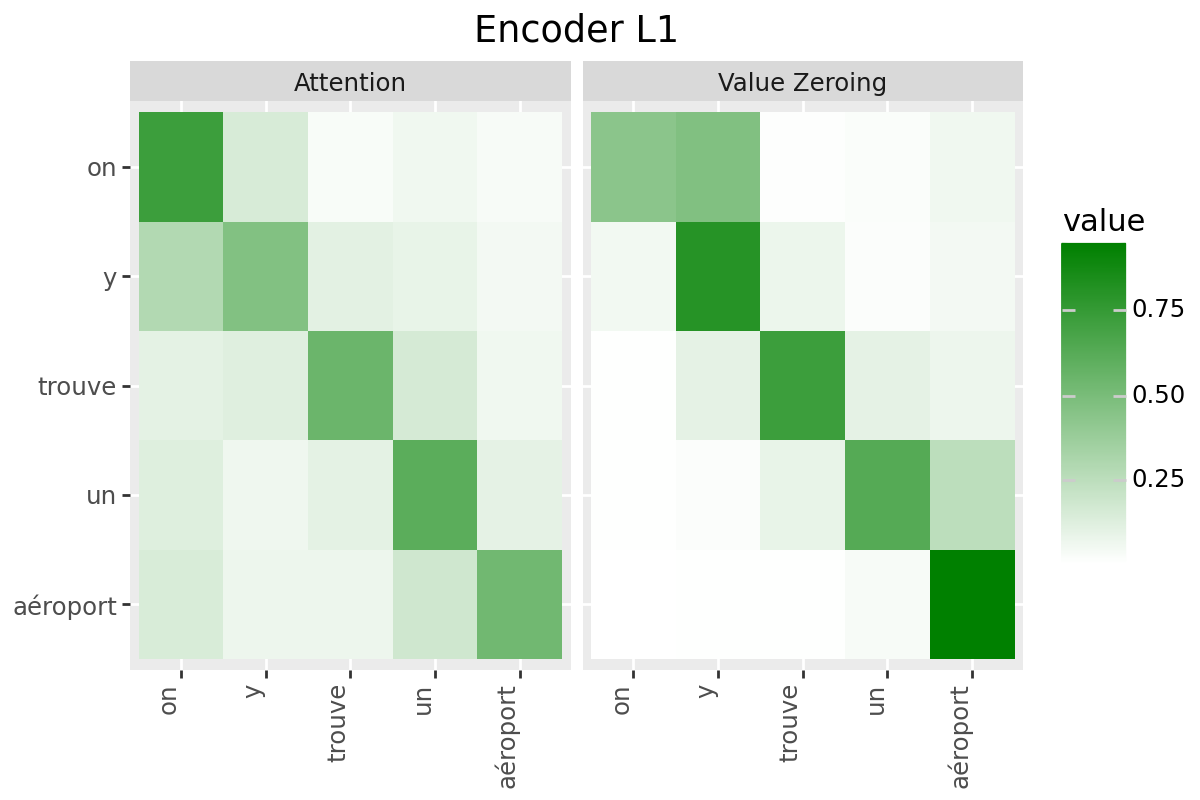

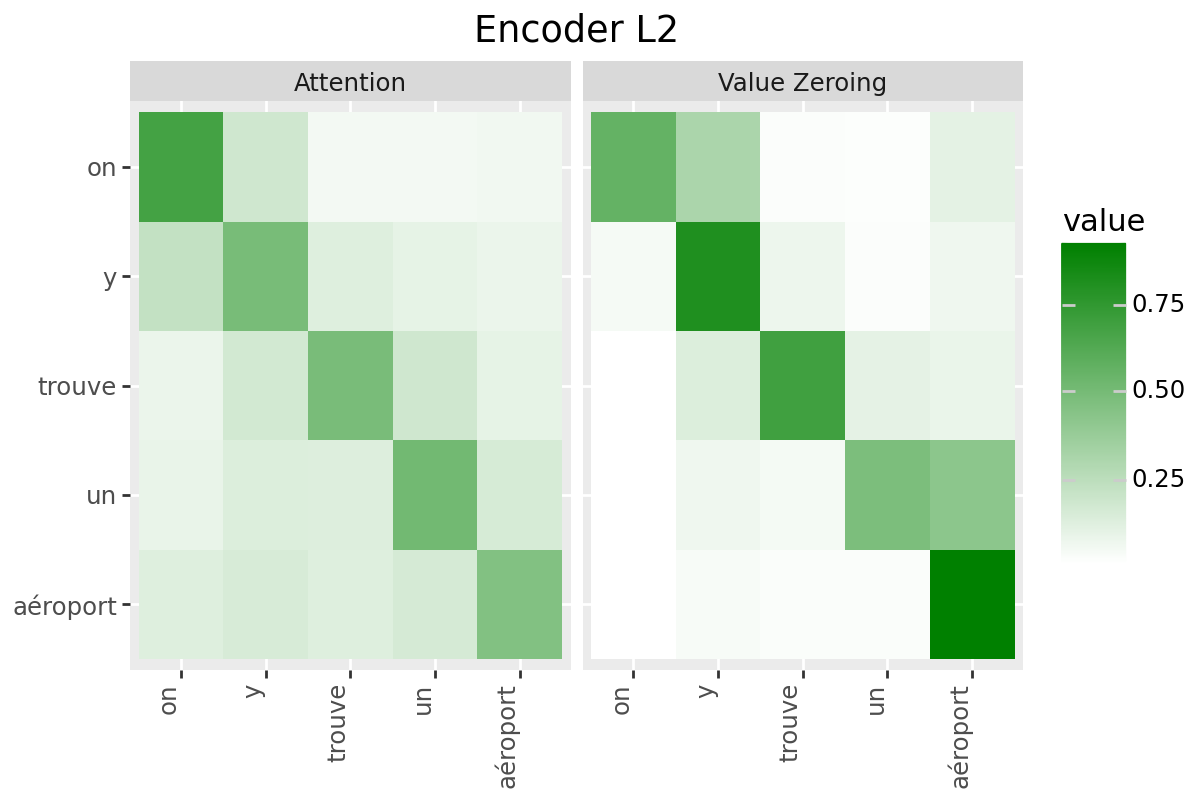

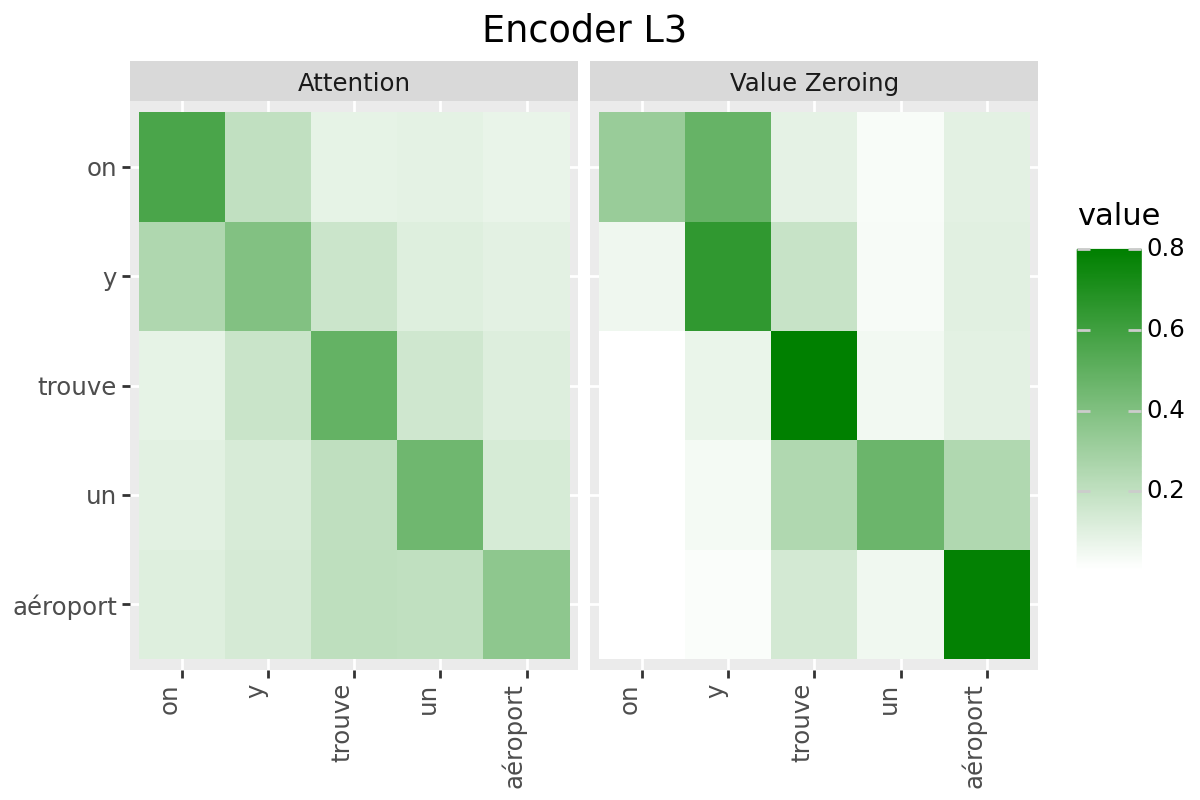

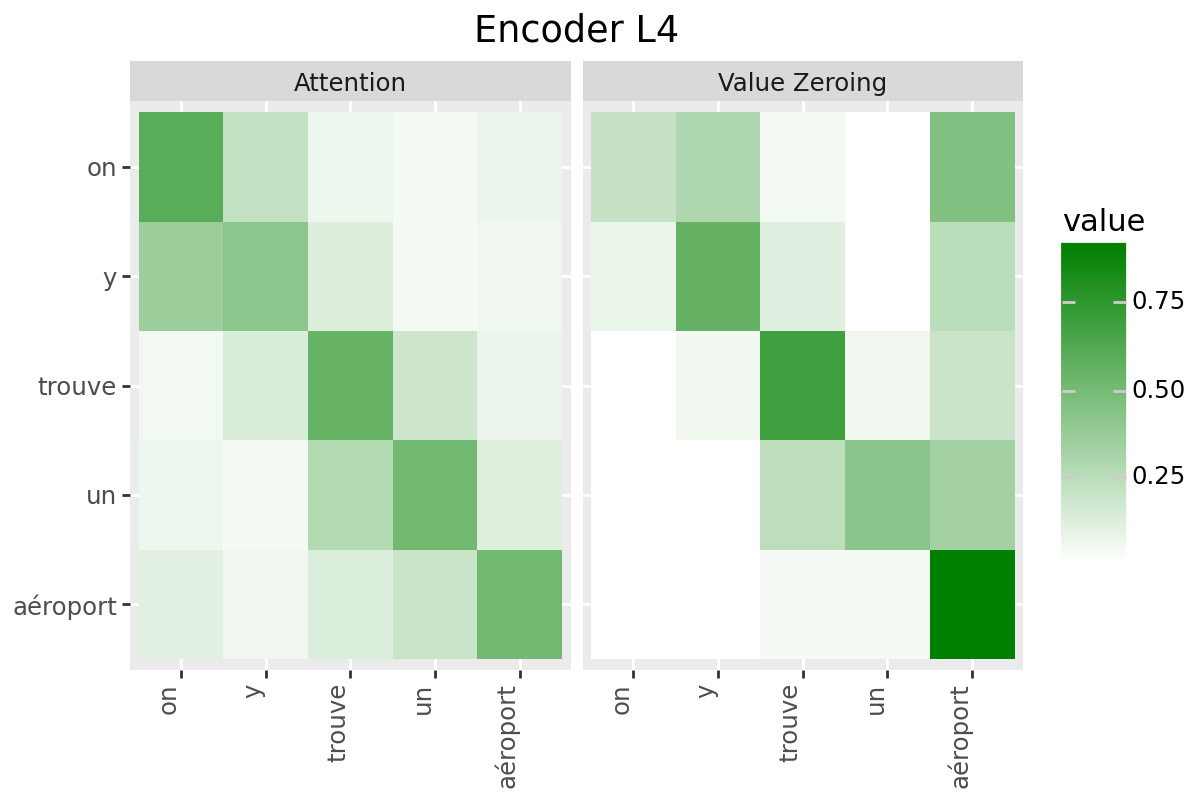

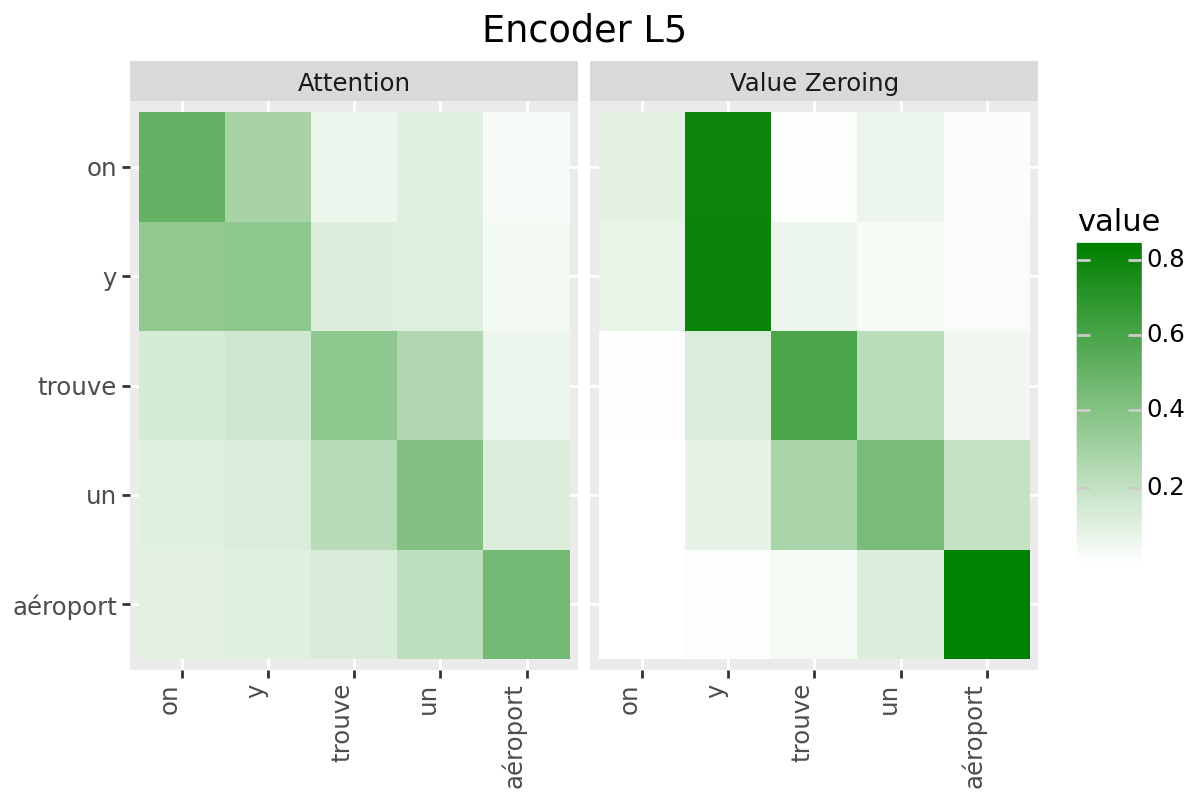

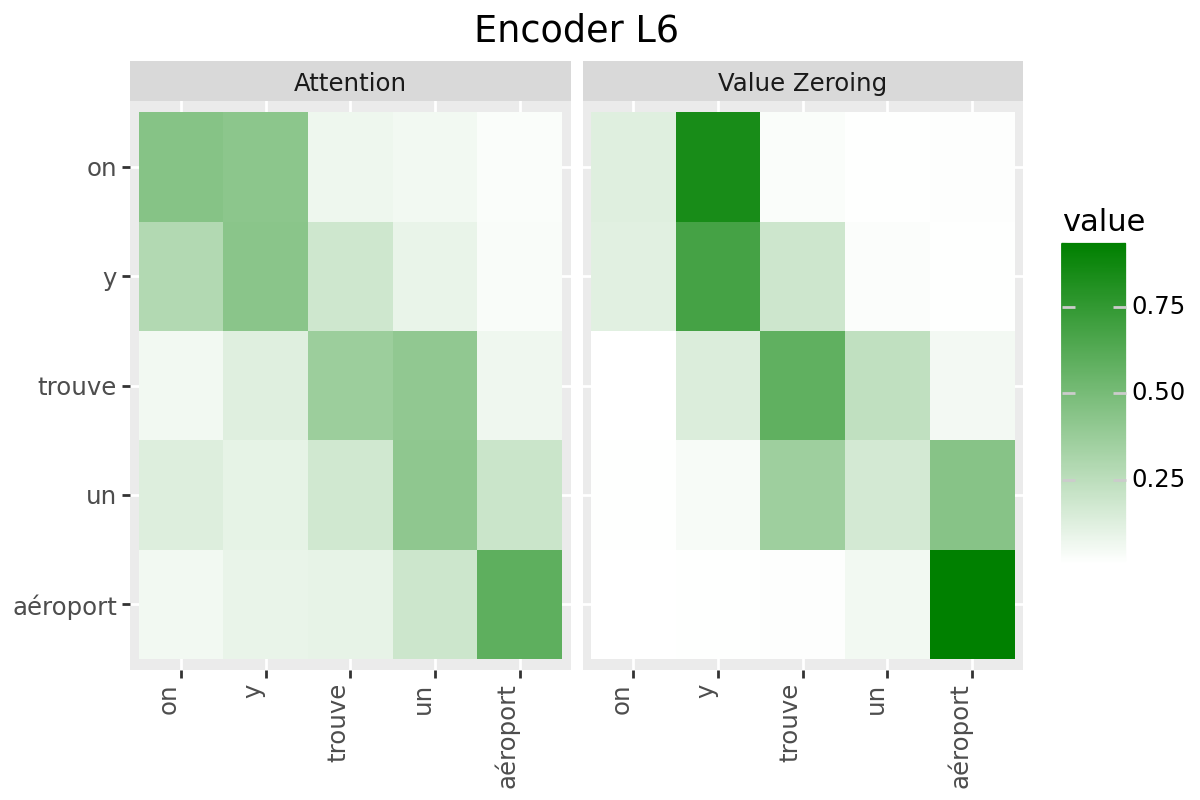

In [ ]:
# @title Plot Scores in Encoder
LAYER = "all" #@param ["all", 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
encoder_tokens = [EXAMPLE['alignment']['intervals'][t]['word'] for t in range(encoder_aligned_length)]
plot_scores(
    scores=encoder_scores,
    x_tokens=encoder_tokens,
    y_tokens=encoder_tokens,
    color='green',
    title_prefix="Encoder",
    num_layers=num_enc_layers,
    layers=LAYER
)

Only if your model has a decoder:

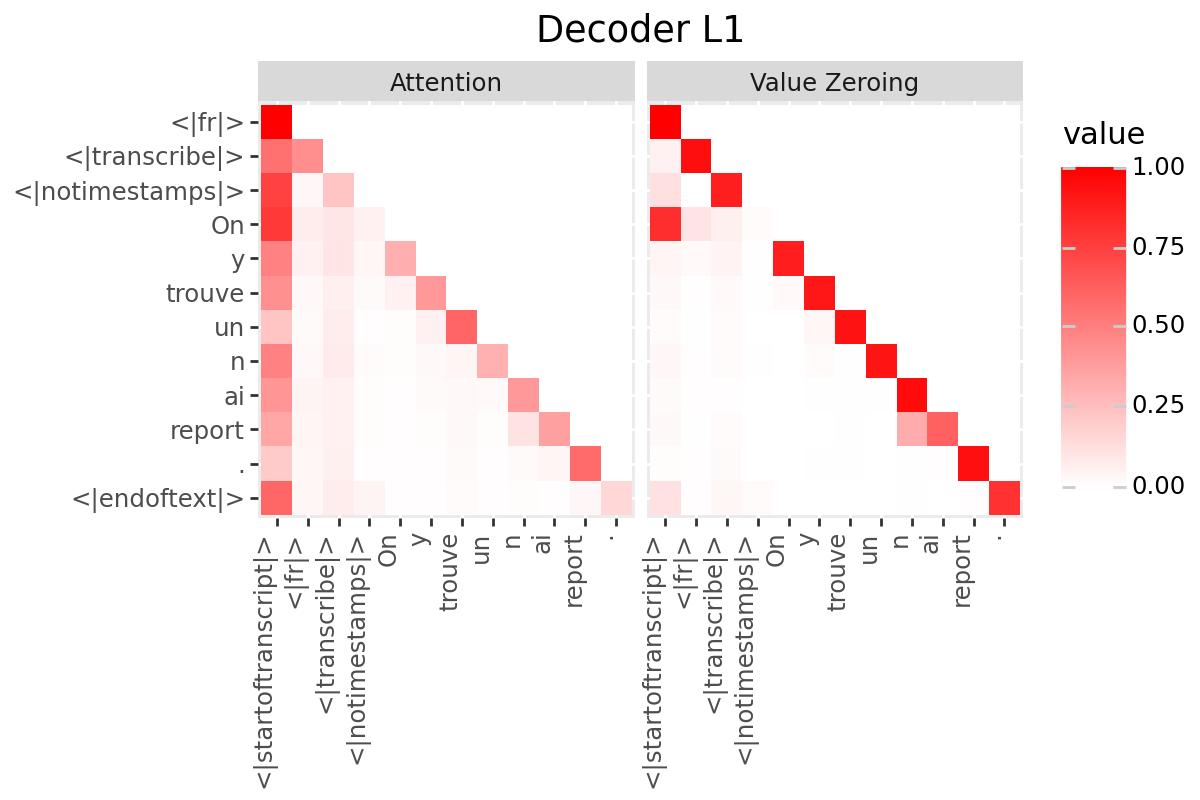

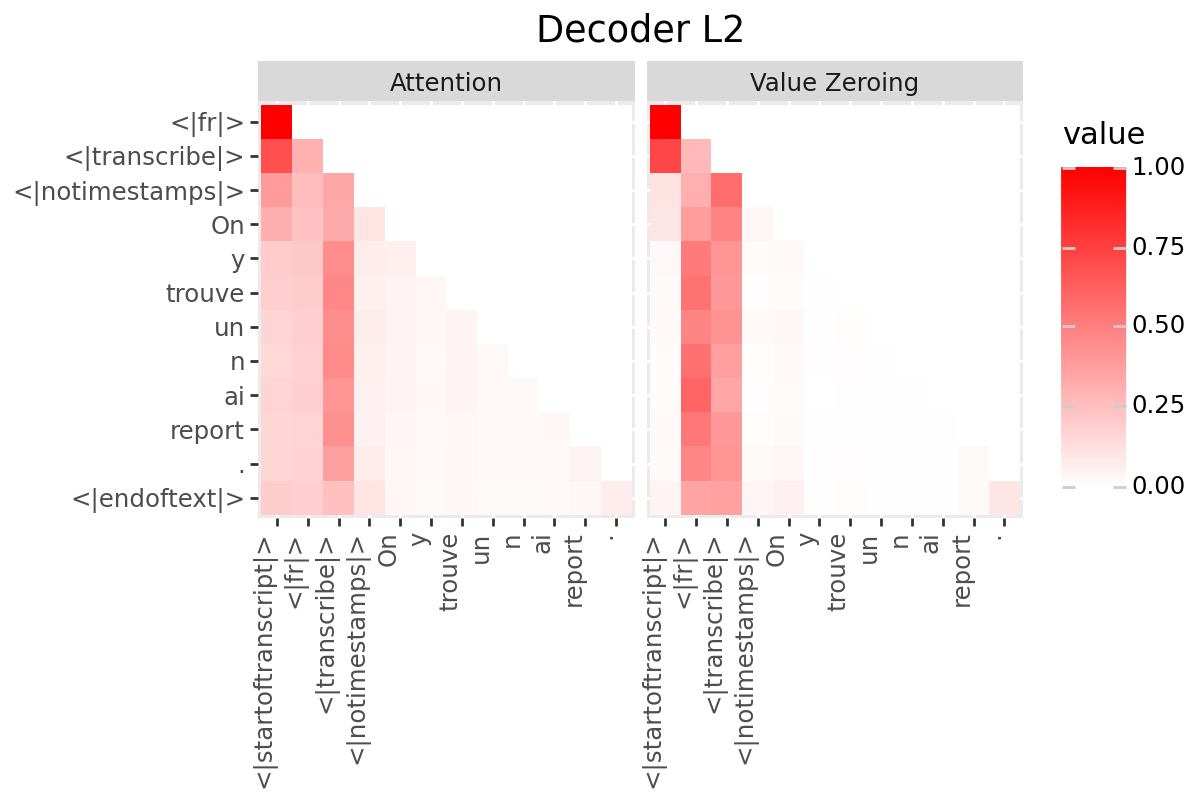

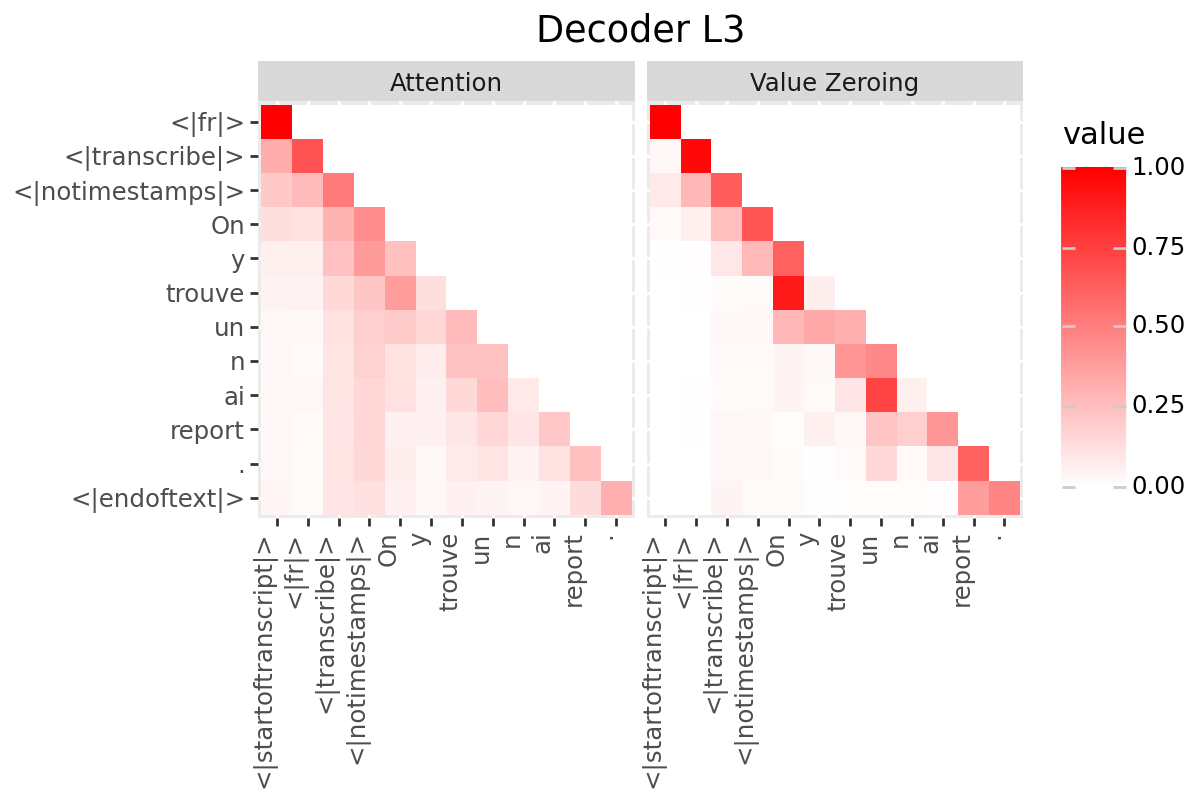

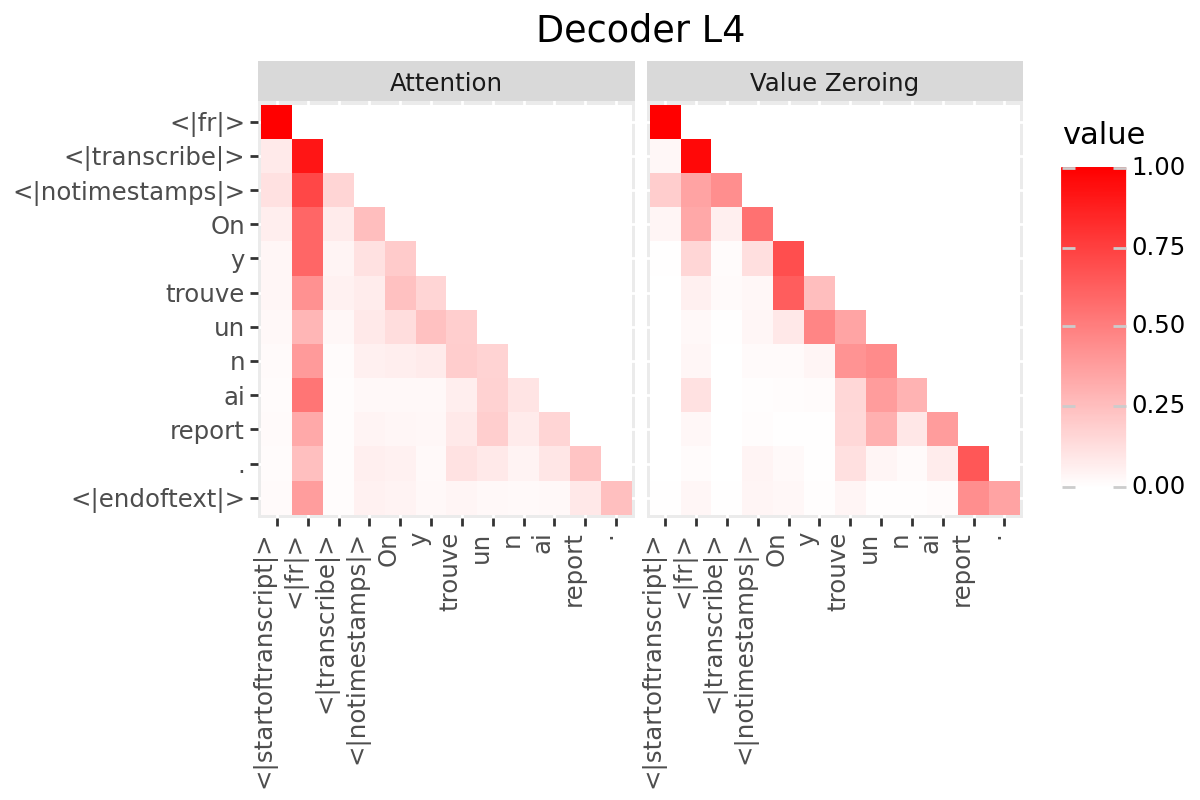

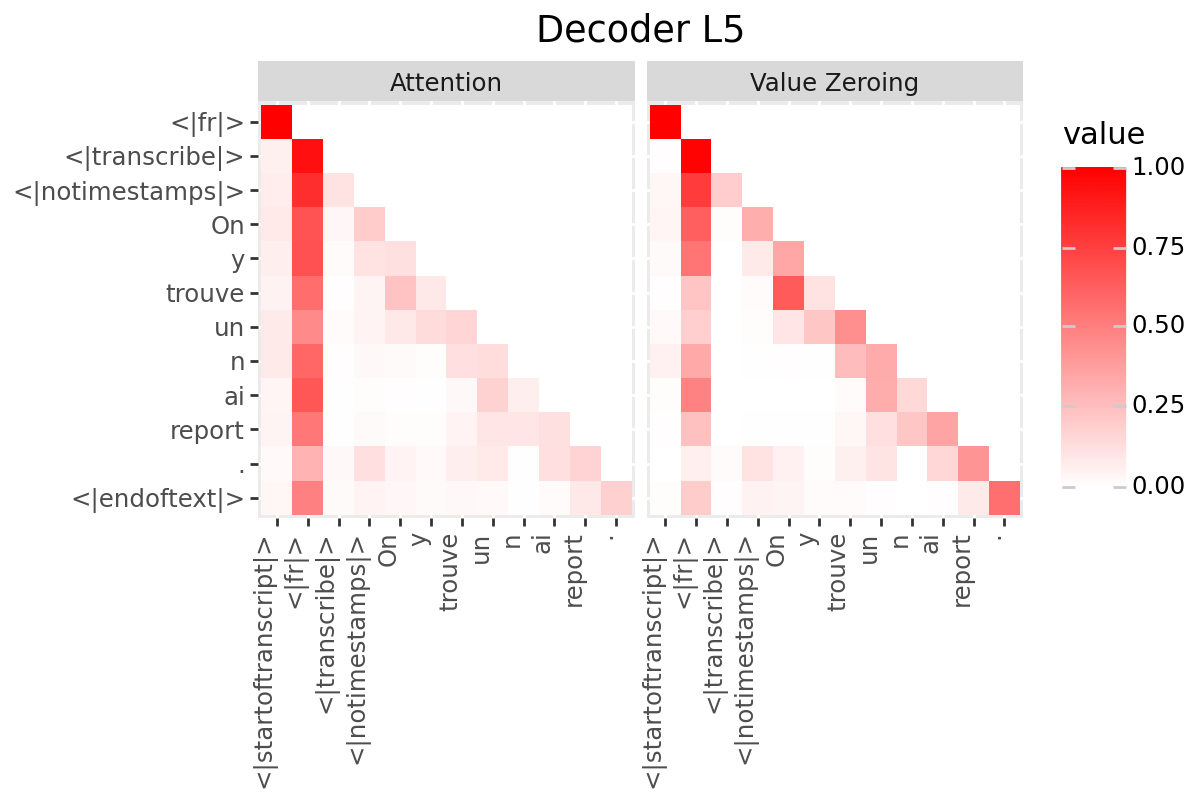

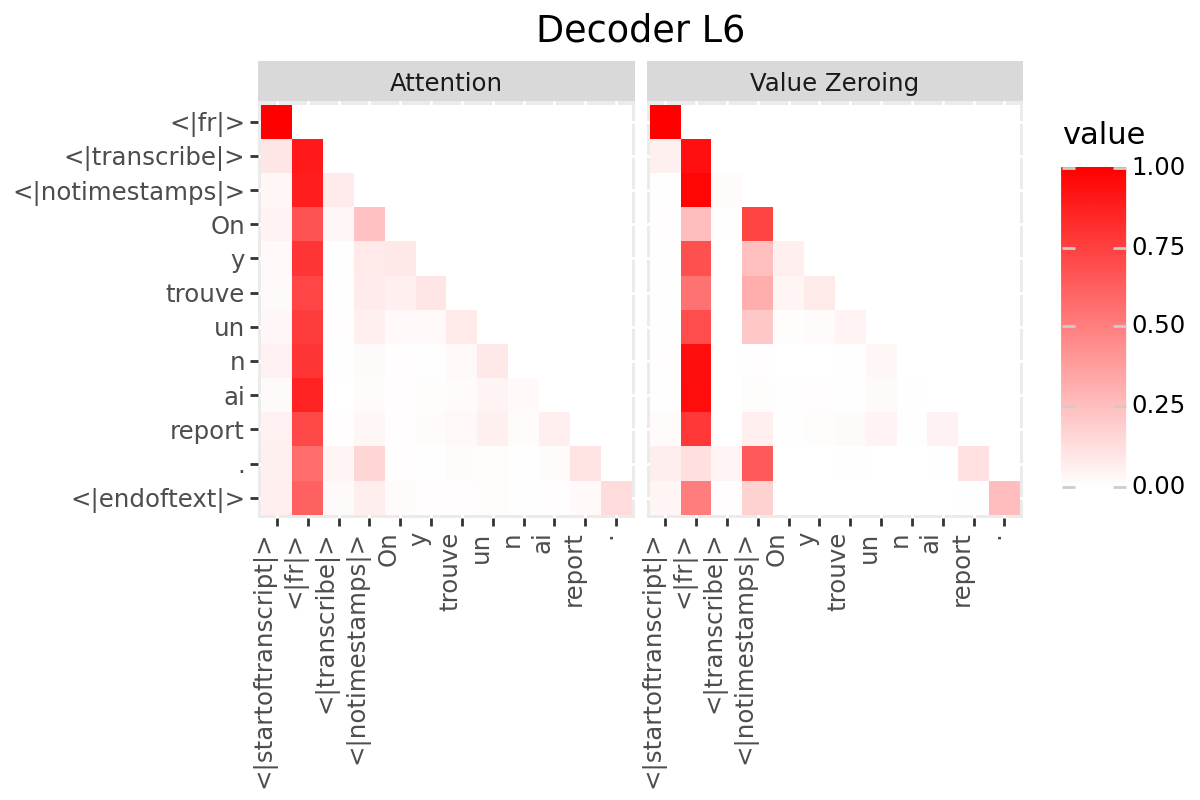

In [ ]:
# @title Plot Scores in Decoder
LAYER = "all" #@param ["all", 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
if is_encoder_decoder:
    decoder_output_tokens = [processor.tokenizer.convert_tokens_to_string(token).strip()
                             for token in processor.tokenizer.convert_ids_to_tokens(generated_ids.tolist())]
    decoder_input_tokens = ['<|startoftranscript|>'] + decoder_output_tokens[:-1]
    plot_scores(
        scores=decoder_scores,
        x_tokens=decoder_input_tokens,
        y_tokens=decoder_output_tokens,
        color='red',
        title_prefix="Decoder",
        num_layers=num_enc_layers,
        layers=LAYER
    )

Only if your model has a decoder:

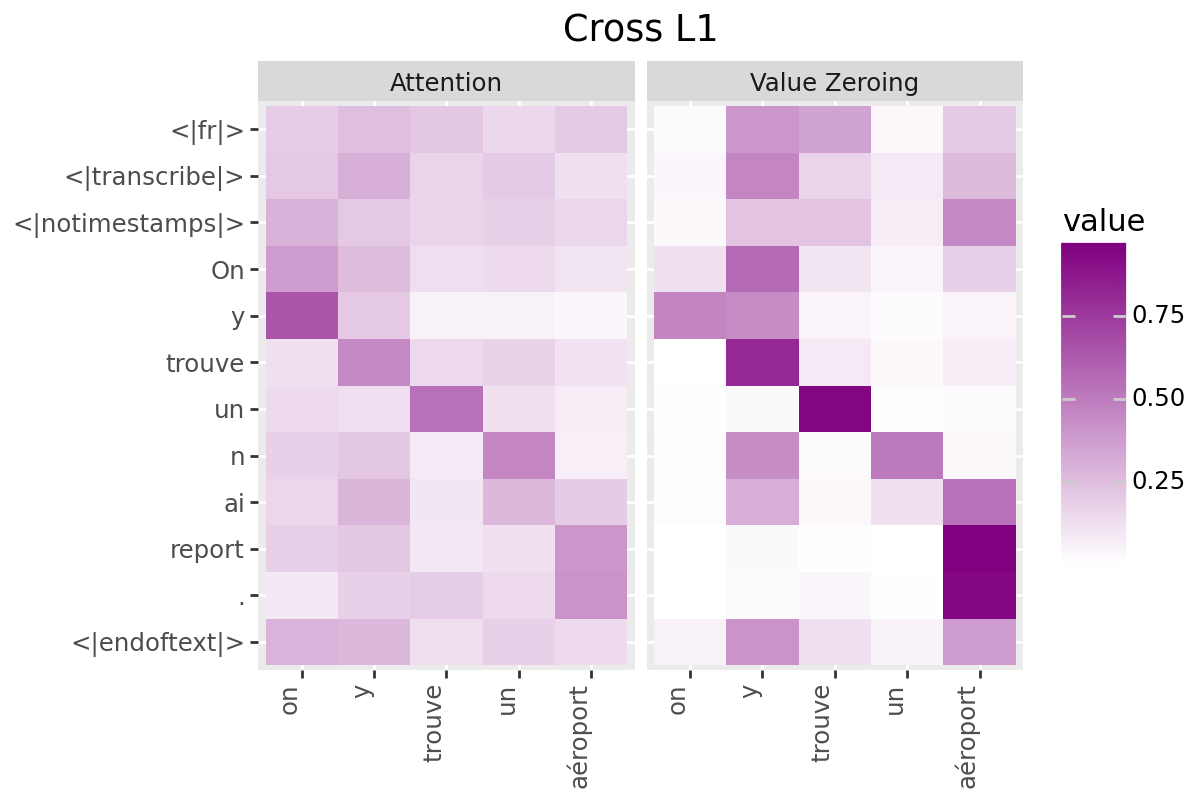

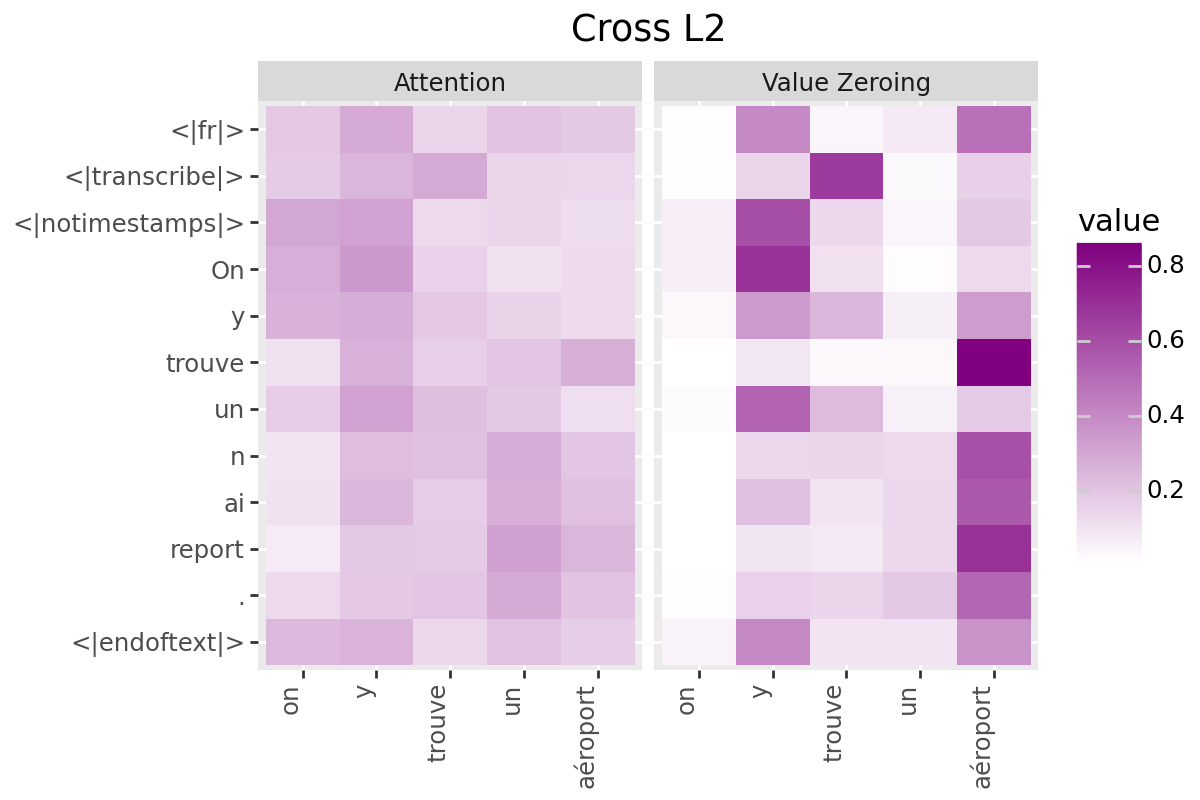

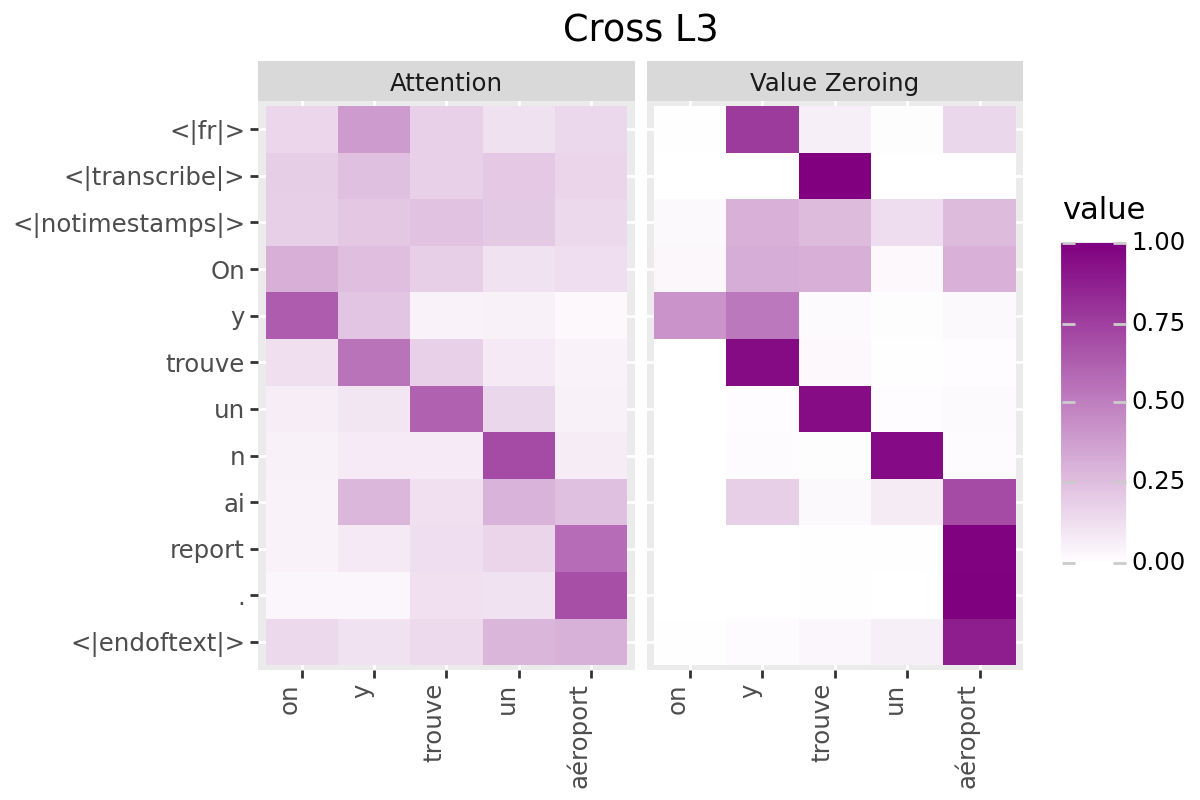

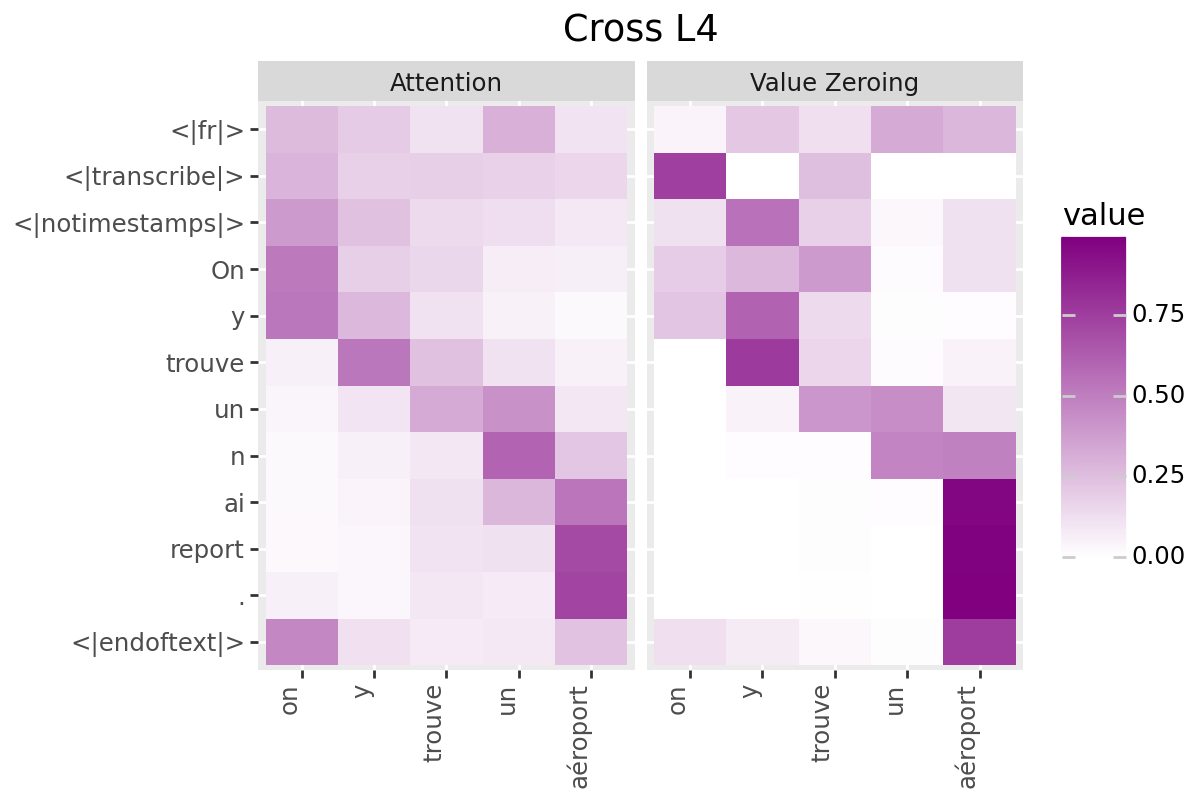

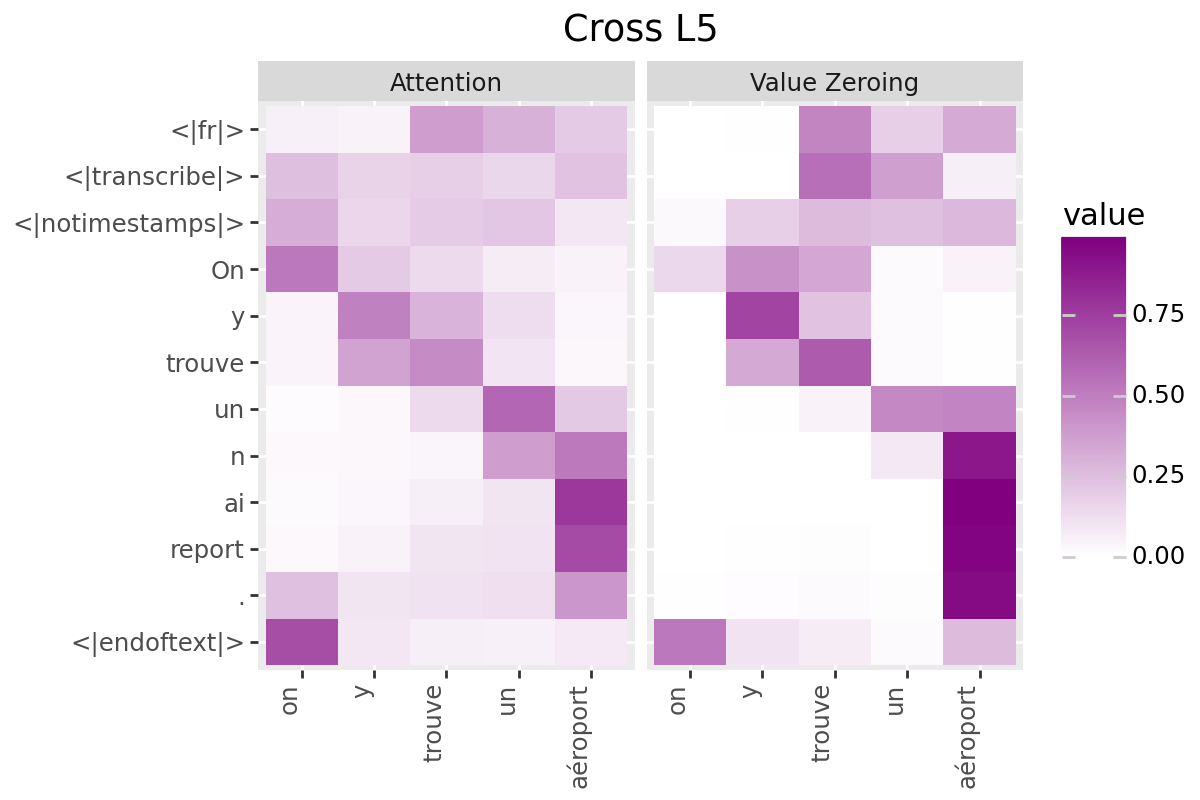

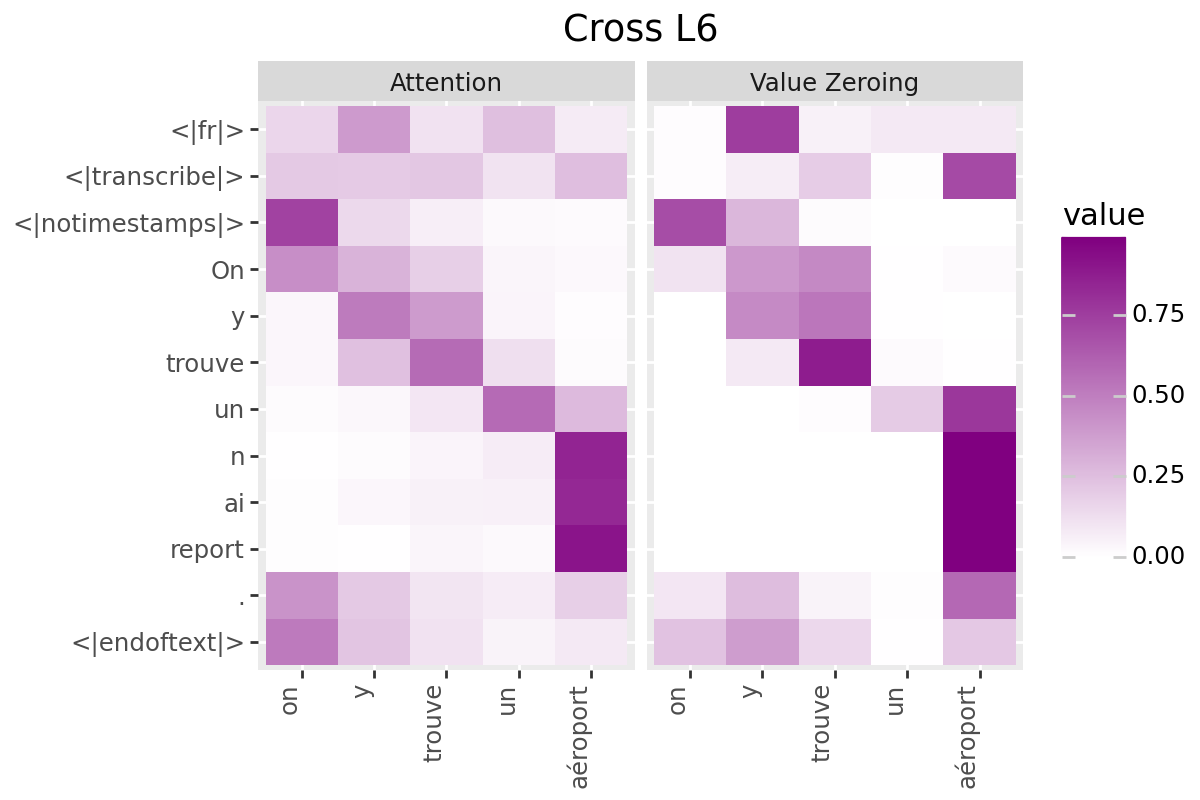

In [ ]:
# @title Plot Scores in Cross (from Decoder to Encoder)
LAYER = "all" #@param ["all", 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
if is_encoder_decoder:
    encoder_tokens = [EXAMPLE['alignment']['intervals'][t]['word'] for t in range(encoder_aligned_length)]
    decoder_output_tokens = [processor.tokenizer.convert_tokens_to_string(token).strip()
                             for token in processor.tokenizer.convert_ids_to_tokens(generated_ids.tolist())]
    plot_scores(
        scores=cross_scores,
        x_tokens=encoder_tokens,
        y_tokens=decoder_output_tokens,
        color='purple',
        title_prefix="Cross",
        num_layers=num_enc_layers,
        layers=LAYER
    )